In [24]:
import os
import torch 
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from dotenv import load_dotenv
import logging
from termcolor import colored

load_dotenv()
log_level = os.getenv("LOG_LEVEL", "INFO").upper()
logging.basicConfig(
    level=getattr(logging, log_level),
    format="%(asctime)s-%(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger(__name__)
logger.info(colored(f"{os.getcwd()}", "green"))

2024-12-21 10:41:10-INFO: c:\Users\lawrence\PycharmProjects\my_lm_log\z_学习案例\猫狗识别模型


In [27]:
def get_transform(train: bool = True) -> T.Compose:
    """
    获取图像变换的组合。

    参数:
    - train (bool): 是否为训练数据。

    返回:
    - T.Compose: 组合的图像变换。
    """
    transform_list = [
        T.Resize((256, 256)),  # 调整图像大小为256x256
        T.ToTensor(),  # 将图像转换为Tensor
        T.ConvertImageDtype(torch.float32),  # 将数据类型转换为float32
    ]

    if train:
        # 数据增强
        transform_list += [
            T.RandomHorizontalFlip(p=0.5),  # 随机水平翻转，概率为0.5
            T.RandomVerticalFlip(p=0.5),  # 随机垂直翻转，概率为0.5
        ]

    return T.Compose(transform_list)

# 加载数据
data_dir = "../../no_git_oic/archive/dogs_vs_cats"
train_data = datasets.ImageFolder(root=f"{data_dir}/train", transform=get_transform(train=True))
valid_data = datasets.ImageFolder(root=f"{data_dir}/test", transform=get_transform(train=False))

logger.info(colored(f"Train data: {train_data}", "green"))
logger.info(colored(f"Validation data: {valid_data}", "green"))

# 获取类别信息
classes = train_data.classes
class_to_idx = train_data.class_to_idx
logger.info(colored(f"Classes: {classes}", "green"))
logger.info(colored(f"Class to index mapping: {class_to_idx}", "green"))
# 将数据分批
batch_size = 50
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)

data_loaders = {"train": train_loader, "valid": valid_loader}

2024-12-21 10:43:06-INFO: Train data: Dataset ImageFolder
    Number of datapoints: 20000
    Root location: ../../no_git_oic/archive/dogs_vs_cats/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               ConvertImageDtype()
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
           )
2024-12-21 10:43:06-INFO: Validation data: Dataset ImageFolder
    Number of datapoints: 5000
    Root location: ../../no_git_oic/archive/dogs_vs_cats/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               ConvertImageDtype()
           )
2024-12-21 10:43:06-INFO: Classes: ['cats', 'dogs']
2024-12-21 10:43:06-INFO: Class to index mapping: {'cats': 0, 'dogs': 1}


In [28]:
from torchvision import utils
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from torch import optim
import time
from tempfile import TemporaryDirectory
from pathlib import *
from torchvision import models

In [29]:
inputs, class_name = next(iter(train_loader))
print(f"{inputs.shape}")
inputs[:1], class_name

torch.Size([50, 3, 256, 256])


(tensor([[[[0.2078, 0.1216, 0.1451,  ..., 0.5137, 0.5059, 0.4941],
           [0.2118, 0.1255, 0.1451,  ..., 0.5176, 0.5098, 0.4980],
           [0.2157, 0.1255, 0.1451,  ..., 0.5255, 0.5176, 0.5059],
           ...,
           [0.2392, 0.2745, 0.4314,  ..., 0.3333, 0.3333, 0.3216],
           [0.3098, 0.3843, 0.5137,  ..., 0.3529, 0.3490, 0.3294],
           [0.3569, 0.4902, 0.6000,  ..., 0.3686, 0.3529, 0.3255]],
 
          [[0.2157, 0.1294, 0.1529,  ..., 0.5216, 0.5137, 0.5020],
           [0.2196, 0.1333, 0.1529,  ..., 0.5255, 0.5176, 0.5059],
           [0.2235, 0.1333, 0.1529,  ..., 0.5333, 0.5255, 0.5137],
           ...,
           [0.2431, 0.2784, 0.4353,  ..., 0.3412, 0.3412, 0.3294],
           [0.3137, 0.3882, 0.5176,  ..., 0.3608, 0.3569, 0.3373],
           [0.3608, 0.4941, 0.6039,  ..., 0.3765, 0.3608, 0.3333]],
 
          [[0.1961, 0.1098, 0.1333,  ..., 0.5020, 0.4941, 0.4824],
           [0.2000, 0.1137, 0.1333,  ..., 0.5059, 0.4980, 0.4863],
           [0.2039, 0.11

grid shape:torch.Size([3, 1292, 2582])


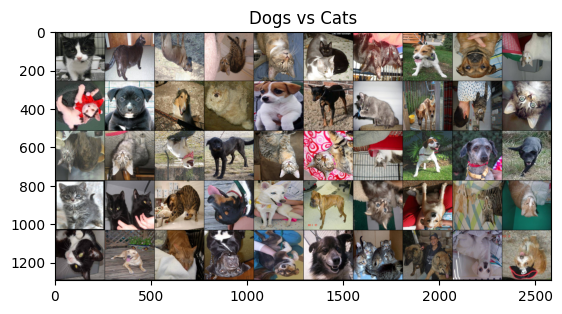

In [32]:
grid = utils.make_grid(inputs[0:50], nrow=10)
# 在 make_grid 中，图像之间会有一定的间距（padding),默认为2
print(f"grid shape:{grid.shape}")
def imageshow(img, title=None):
    img = img.numpy().transpose(
        (1, 2, 0)
    )  # tensor(channel,width,heigth) →numpy (width,heigth,channel) 因为plt.imshow需要的是(w,h,c)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
imageshow(grid, title="Dogs vs Cats")

In [ ]:
"""
self.conv1 的 in_channels=3 是因为输入图像的通道数为 3
self.conv1 的 out_channels 设置为 128 或 32 都是可以的，具体选择取决于任务需求和资源限制。
stride=1: 步幅为1意味着卷积核在输入图像上每次移动1个像素。
kernel_size=3: 卷积核的大小为3x3。3x3的卷积核是深度学习中最常用的卷积核大小之一
padding=1: 填充为1意味着在输入图像的边缘添加1个像素的填充。

卷积层==>池化层==>全连接层==>激活函数==>Dropout
"""
class Dogs_vs_Cats_Net(nn.Module):
    def __init__(self):
        super(Dogs_vs_Cats_Net, self).__init__()
        self.conv1 = nn.Conv2d(3,128,stride = 1 , kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(128,64,stride = 1, kernel_size = 1, padding = 0)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
